In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split


In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-19 21:16:16--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.2’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-10-19 21:16:17 (1.14 MB/s) - ‘course_lead_scoring.csv.2’ saved [80876/80876]



In [3]:
url = 'course_lead_scoring.csv'
df = pd.read_csv(url)
print(df.head())

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [36]:
df.lead_source = df.lead_source.fillna('NA')
df.industry = df.industry.fillna('NA')
df.annual_income = df.annual_income.fillna(0.0)
df.employment_status = df.employment_status.fillna('NA')
df.location = df.location.fillna('NA')

In [37]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)


(876, 293, 293)

In [38]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [39]:
y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values


In [40]:
numerical = ['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [41]:
# Prepare X and y for each split
X_train = df_train.drop('converted', axis=1)
y_train = df_train['converted'].values

X_val = df_val.drop('converted', axis=1)
y_val = df_val['converted'].values

X_test = df_test.drop('converted', axis=1)
y_test = df_test['converted'].values

X_full_train = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted'].values

del df_train['converted']
del df_test['converted']
del df_val['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [53]:
features_to_test = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for feature in features_to_test:
    scores = df_train[feature].values
    
    # Calculate AUC
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        scores_inverted = -scores
        auc_inverted = roc_auc_score(y_train, scores_inverted)
        auc_scores[feature] = auc_inverted
    else:
        auc_scores[feature] = auc

best_feature = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_feature]

print(f" ANSWER Q1: {best_feature} (AUC: {best_auc:.4f})")


 ANSWER Q1: number_of_courses_viewed (AUC: 0.7636)


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [72]:
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

auc_val = roc_auc_score(y_val, y_val_pred_proba)

print(f"ANSWER Q2: {auc_val:.3f}")

ANSWER Q2: 0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

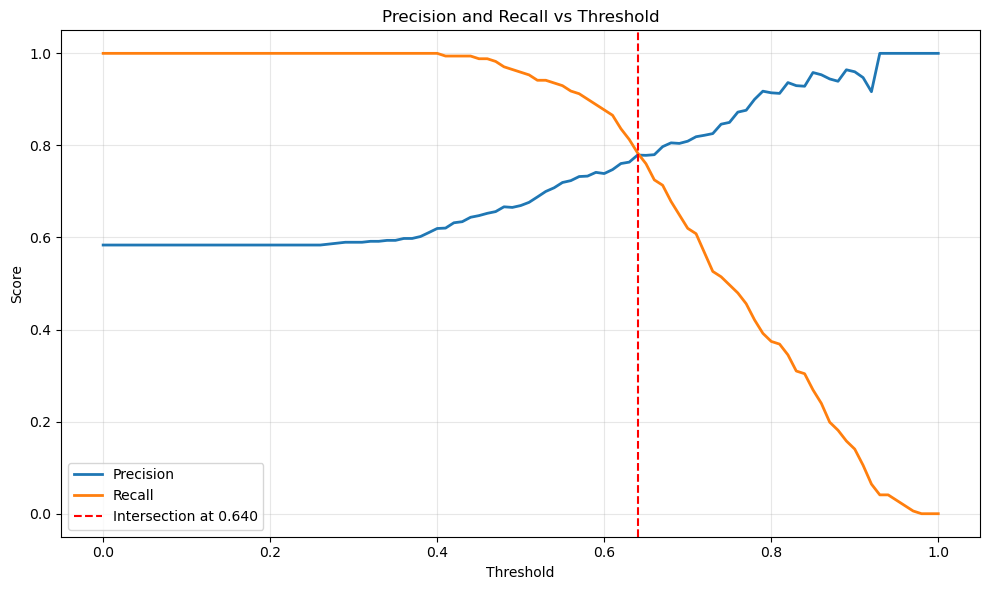

ANSWER Q3: 0.640


In [73]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    
    if y_val_pred.sum() == 0:
        precision = 1.0
        recall = 0.0
    else:
        precision = precision_score(y_val, y_val_pred, zero_division=0)
        recall = recall_score(y_val, y_val_pred, zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

differences = np.abs(precision_scores - recall_scores)
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.axvline(x=intersection_threshold, color='r', linestyle='--', 
           label=f'Intersection at {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ANSWER Q3: {intersection_threshold:.3f}")


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74



Maximum F1 Score:
  Threshold: 0.570
  F1 Score: 0.812


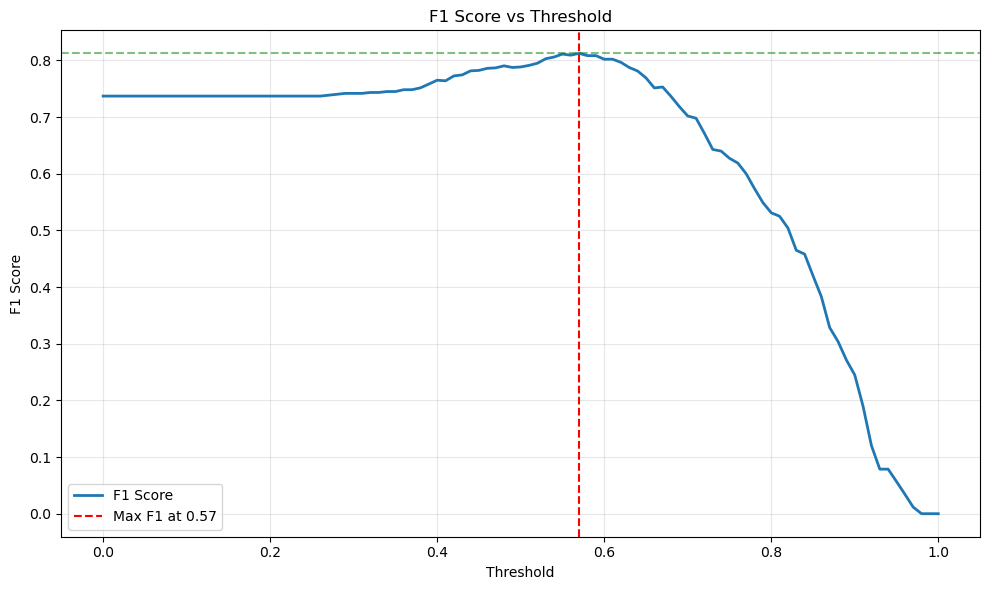

ANSWER Q4: 0.57


In [74]:
f1_scores = []

for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"\nMaximum F1 Score:")
print(f"  Threshold: {max_f1_threshold:.3f}")
print(f"  F1 Score: {max_f1_value:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, label='F1 Score')
plt.axvline(x=max_f1_threshold, color='r', linestyle='--', 
           label=f'Max F1 at {max_f1_threshold:.2f}')
plt.axhline(y=max_f1_value, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ANSWER Q4: {max_f1_threshold:.2f}")


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


In [77]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

fold_scores = []

full_train_dicts = X_full_train.to_dict(orient='records')

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train), 1):
    X_fold_train = [full_train_dicts[i] for i in train_idx]
    X_fold_val = [full_train_dicts[i] for i in val_idx]
    y_fold_train = y_full_train[train_idx]
    y_fold_val = y_full_train[val_idx]
    
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train_encoded = dv_fold.fit_transform(X_fold_train)
    X_fold_val_encoded = dv_fold.transform(X_fold_val)
    
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train_encoded, y_fold_train)
    
    y_fold_val_pred_proba = model_fold.predict_proba(X_fold_val_encoded)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_fold_val_pred_proba)
    
    fold_scores.append(auc_fold)

# Calculate mean and std
fold_scores = np.array(fold_scores)
mean_auc = fold_scores.mean()
std_auc = fold_scores.std()

print(f"\nCross-Validation Results:")
print(f"  Mean AUC: {mean_auc:.4f}")
print(f"  Std AUC: {std_auc:.6f}")

print(f"ANSWER Q5: {std_auc:.4f}")



Cross-Validation Results:
  Mean AUC: 0.8221
  Std AUC: 0.035807
ANSWER Q5: 0.0358


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

 ANSWER Q6: C = 0.001
   Mean AUC: 0.867
   Std: 0.029


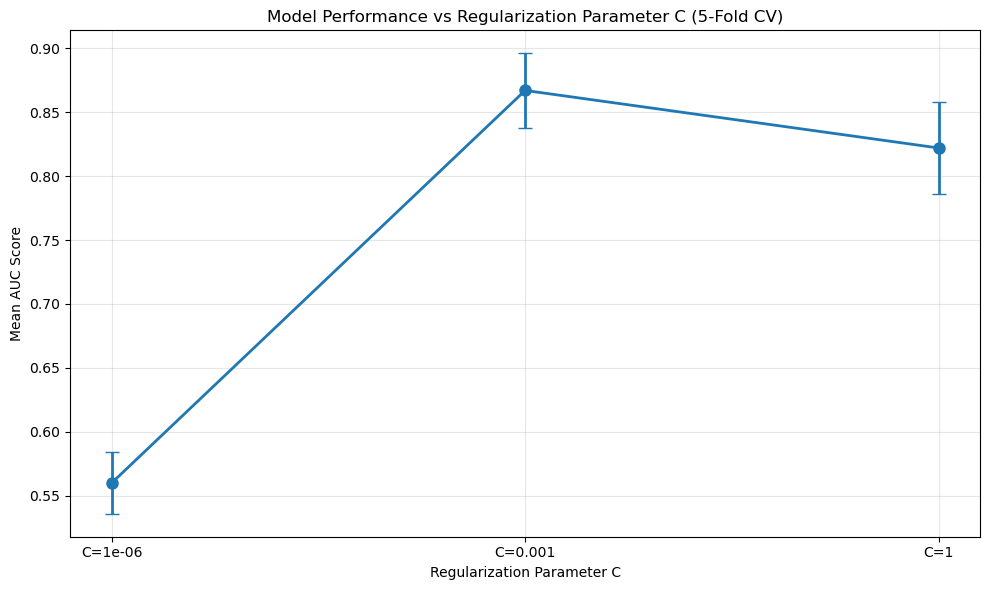

In [86]:
C_values = [0.000001, 0.001, 1]

results = {}

for C in C_values:
    kf_c = KFold(n_splits=5, shuffle=True, random_state=1)
    
    c_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf_c.split(X_full_train), 1):
        X_fold_train = [full_train_dicts[i] for i in train_idx]
        X_fold_val = [full_train_dicts[i] for i in val_idx]
        y_fold_train = y_full_train[train_idx]
        y_fold_val = y_full_train[val_idx]
        
        dv_c = DictVectorizer(sparse=False)
        X_fold_train_encoded = dv_c.fit_transform(X_fold_train)
        X_fold_val_encoded = dv_c.transform(X_fold_val)
        
        model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_c.fit(X_fold_train_encoded, y_fold_train)
        
        y_fold_val_pred_proba = model_c.predict_proba(X_fold_val_encoded)[:, 1]
        auc_c = roc_auc_score(y_fold_val, y_fold_val_pred_proba)
        
        c_scores.append(auc_c)
    
    c_scores = np.array(c_scores)
    mean_c = round(c_scores.mean(), 3)
    std_c = round(c_scores.std(), 3)
    
    results[C] = {
        'mean': mean_c,
        'std': std_c,
        'scores': c_scores
    }
    

best_mean = max([results[C]['mean'] for C in C_values])
candidates = [C for C in C_values if results[C]['mean'] == best_mean]

if len(candidates) > 1:
    best_std = min([results[C]['std'] for C in candidates])
    candidates = [C for C in candidates if results[C]['std'] == best_std]
    
    if len(candidates) > 1:
        best_C = min(candidates)
    else:
        best_C = candidates[0]
else:
    best_C = candidates[0]

print(f" ANSWER Q6: C = {best_C}")
print(f"   Mean AUC: {results[best_C]['mean']:.3f}")
print(f"   Std: {results[best_C]['std']:.3f}")

plt.figure(figsize=(10, 6))
means = [results[C]['mean'] for C in C_values]
stds = [results[C]['std'] for C in C_values]

plt.errorbar(range(len(C_values)), means, yerr=stds, marker='o', 
            markersize=8, capsize=5, linewidth=2)
plt.xticks(range(len(C_values)), [f'C={C}' for C in C_values])
plt.xlabel('Regularization Parameter C')
plt.ylabel('Mean AUC Score')
plt.title('Model Performance vs Regularization Parameter C (5-Fold CV)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()